# PRACTICE BUILDING TESTBEDS

This notebook poses a sequences of problems for building testbeds.

## Preliminaries

In [1]:
import controlSBML as ctl

import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
from IPython.display import Image
from IPython.core.display import HTML
ctl.__version__

'1.0.5'

# Models

## Linear model

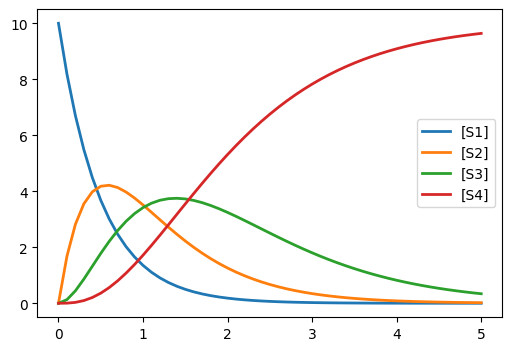

In [2]:
LINEAR_MDL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
LINEAR_RR = te.loada(LINEAR_MDL)
LINEAR_DATA = LINEAR_RR.simulate()
LINEAR_RR.plot(LINEAR_DATA)
LINEAR_STATE_NAMES = ["S1", "S2", "S3", "S4"]
LINEAR_PARAM_DCT = {"input_names": LINEAR_STATE_NAMES, "output_names": LINEAR_STATE_NAMES}

## WOLF model

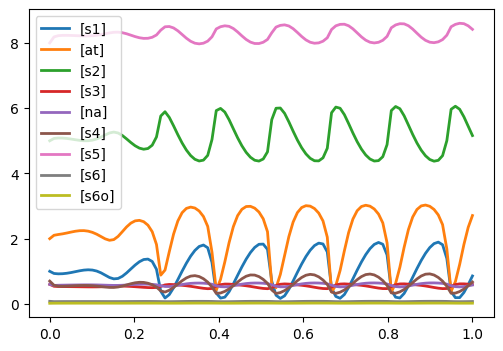

In [3]:
WOLF_CTLSB = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml", 
                        input_names=["at"], output_names=["s5"])
WOLF_RR = WOLF_CTLSB.roadrunner
WOLF_RR.simulate(0, 1, 100)
WOLF_RR.plot()

In [4]:
WOLF_ANT = WOLF_RR.getAntimony()
print(WOLF_ANT)

// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

# Helpers

In [5]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""

In [6]:
ctlsb = ctl.ControlSBML(TEST_MODEL, input_names=["S1"], output_names=["S2"])
TEST_SYS = ctlsb.makeNonlinearIOSystem("TEST_SYS")

# Review: Closed loop testbed for Wolf

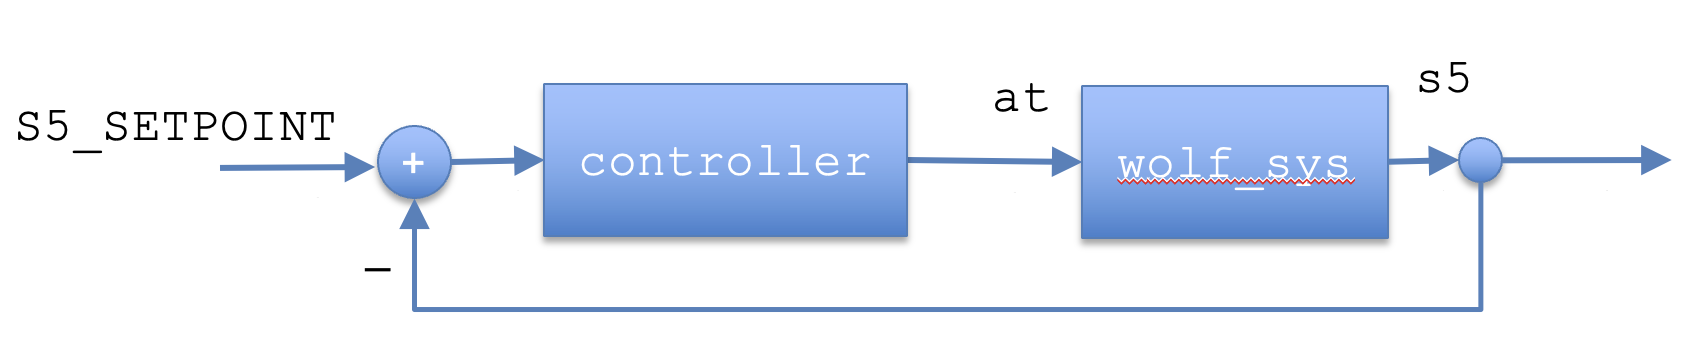

In [7]:
Image("wolf_cls.png", width = 600, height = 300)

This example explores the use of feedback control to regulate the concentration of pyruvate in
a model of glycolytic oscillations (BioModels 206).

Pyruvate is ``s5`` in the model.
It is regulated using ATP, species ``at`` in the model.

Below is the behavior of the unregulated system.
Note the oscillations in ``s5``.

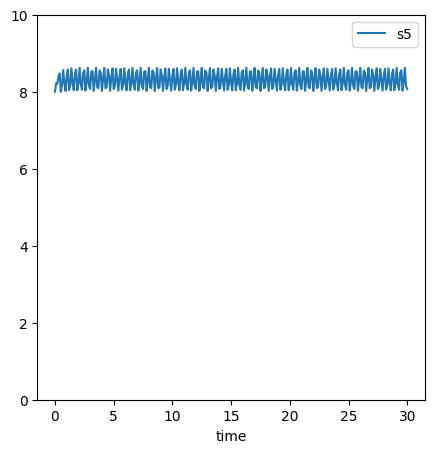

In [8]:
# Simulate the open loop system with no change in its input (at)
wolf_sys = WOLF_CTLSB.makeNonlinearIOSystem("wolf_sys")
ts = ctl.simulateSystem(wolf_sys, end_time=30)
_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[0, 10])

**Control Objectives**

1. Eliminate the oscillations from ``s5``
1. Coverge to 6.

Next, we construct a PI controller.

In [9]:
S5_SETPOINT = 6

In [10]:
def makePIController(setpoint=S5_SETPOINT, kP=20, kI=10):
    """
    Makes a PI controller
    
    Parameters
    ----------
    setpoint: float
    kP: float
    kI: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate derivative of state
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (output from OLS)
        # returns: array-float (derivative of state)
        dx = setpoint - u[0]
        return dx

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        new_err = setpoint - u[0]
        output = kI*x[0] + kP*new_err
        return output

    controller = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name='controller_sys')
    return controller

# Tests
controller = makePIController()
assert("NonlinearIOSystem" in str(type(controller)))
print("OK")

OK


We form a closed loop system so that the output of the glycolytic system, ``sys.s5``, is
the input the the controller, ``controller.in``.
And, the output of the controller, ``controller.out``, is the input the glycolytic system.

In [11]:
def makeInterconnect(wolf_sys=wolf_sys, **kwargs):
    """
    Create an Interconnect object for the Wolf closed loop system.
    
    Parameters
    ----------
    wolf_sys: NonlinearIOSystem
    kwargs: dict (arguments for makePIController)
    
    Returns
    -------
    Interconnect
    """
    controller_sys = makePIController(**kwargs)
    closed_sys = control.interconnect(
      [wolf_sys, controller_sys],       # systems
      connections=[
        ['wolf_sys.at', 'controller_sys.out'],
        ['controller_sys.in',  'wolf_sys.s5'],
      ],
      inplist=["controller_sys.in"],
      outlist=["wolf_sys.s5"],
    )
    return closed_sys

# Tests
interconnect = makeInterconnect()
assert("Interconnect" in str(type(interconnect)))
print("OK!")

OK!


Now, we simulate the closed loop system.
Note that we have eliminated oscillations, and ``s5`` converges to 6.

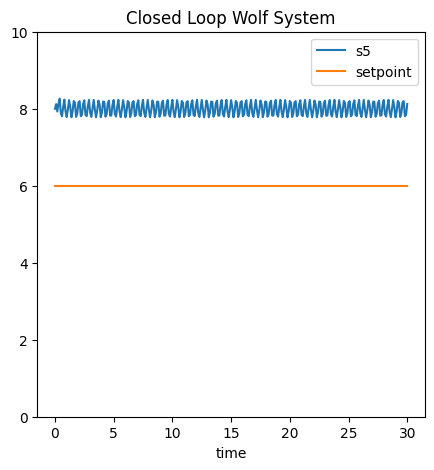

In [12]:
closed_sys = makeInterconnect(kP=1, kI=0)
end_time = 30
ts = ctl.simulateSystem(closed_sys, end_time=end_time, output_names=["s5"])
ts["setpoint"] = S5_SETPOINT
# Plot the resultkkk
_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[0, 10], title="Closed Loop Wolf System")

We see that the control system has achieved its objectives.

# Creating a filter